In [1]:

#------------------------------------------------------------------------------+
#
#   Simple implementation of Support Vector Machine algorithm
#   2024 (April)
#
#   Inspired by https://domino.ai/blog/fitting-support-vector-machines-quadratic-programming
#------------------------------------------------------------------------------+

#--- IMPORT DEPENDENCIES ------------------------------------------------------+
import numpy as np
import cvxopt

from numpy import linalg

#--- ANCILLARY FUNCTIONS  -----------------------------------------------------+

def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def gaussian_kernel(x1, x2, sigma=1.0):
    return np.exp(-linalg.norm(x1-x2)**2 / (2 * (sigma ** 2)))

#--- MAIN ---------------------------------------------------------------------+


class SVM(object):

    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C

    # Train model using dataset (X, y)
    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Define Gram matrix using the kernel
        G = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                G[i,j] = self.kernel(X[i], X[j])

        Q = cvxopt.matrix(np.outer(y,y) * G)
        c = cvxopt.matrix(-1 * np.ones(n_samples))
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)

        # Hard SVM model (positivity constraint)
        if self.C is None:
            B = cvxopt.matrix(np.diag(-1 * np.ones(n_samples)))
            h = cvxopt.matrix(np.zeros(n_samples))

        # Soft SVM model  (positivity constraint + nonzero error constraint)
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            B = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # Solve QP problem
        solution = coneqp(Q, c, B, h, None, A, b)
        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        S = (a > 1e-5).flatten()

        # Extract support vectors
        self.a = a[S]
        self.sv = X[S]
        self.sv_y = y[S]

        # Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None

        # Intercept
        self.b = np.mean(y[S] - np.dot(X[S], (self.w).reshape(-1,1)))

    # Predict the class of data points X
    def predict(self, X):
        if self.w is not None:
            projection = np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s

            projection = y_predict + self.b

        return np.sign(projection)


In [29]:
import sys
if sys.version > '3': long = int

options = {}

def coneqp(P, q, G = None, h = None, dims = None, A = None, b = None,
    initvals = None, kktsolver = None, xnewcopy = None, xdot = None,
    xaxpy = None, xscal = None, ynewcopy = None, ydot = None, yaxpy = None,
    yscal = None, **kwargs):
    """

    Solves a pair of primal and dual convex quadratic cone programs

        minimize    (1/2)*x'*P*x + q'*x
        subject to  G*x + s = h
                    A*x = b
                    s >= 0

        maximize    -(1/2)*(q + G'*z + A'*y)' * pinv(P) * (q + G'*z + A'*y)
                    - h'*z - b'*y
        subject to  q + G'*z + A'*y in range(P)
                    z >= 0.

    The inequalities are with respect to a cone C defined as the Cartesian
    product of N + M + 1 cones:

        C = C_0 x C_1 x .... x C_N x C_{N+1} x ... x C_{N+M}.

    The first cone C_0 is the nonnegative orthant of dimension ml.
    The next N cones are 2nd order cones of dimension mq[0], ..., mq[N-1].
    The second order cone of dimension m is defined as

        { (u0, u1) in R x R^{m-1} | u0 >= ||u1||_2 }.

    The next M cones are positive semidefinite cones of order ms[0], ...,
    ms[M-1] >= 0.


    Input arguments (basic usage).

        P is a dense or sparse 'd' matrix of size (n,n) with the lower
        triangular part of the Hessian of the objective stored in the
        lower triangle.  Must be positive semidefinite.

        q is a dense 'd' matrix of size (n,1).

        dims is a dictionary with the dimensions of the components of C.
        It has three fields.
        - dims['l'] = ml, the dimension of the nonnegative orthant C_0.
          (ml >= 0.)
        - dims['q'] = mq = [ mq[0], mq[1], ..., mq[N-1] ], a list of N
          integers with the dimensions of the second order cones
          C_1, ..., C_N.  (N >= 0 and mq[k] >= 1.)
        - dims['s'] = ms = [ ms[0], ms[1], ..., ms[M-1] ], a list of M
          integers with the orders of the semidefinite cones
          C_{N+1}, ..., C_{N+M}.  (M >= 0 and ms[k] >= 0.)
        The default value of dims = {'l': G.size[0], 'q': [], 's': []}.

        G is a dense or sparse 'd' matrix of size (K,n), where

            K = ml + mq[0] + ... + mq[N-1] + ms[0]**2 + ... + ms[M-1]**2.

        Each column of G describes a vector

            v = ( v_0, v_1, ..., v_N, vec(v_{N+1}), ..., vec(v_{N+M}) )

        in V = R^ml x R^mq[0] x ... x R^mq[N-1] x S^ms[0] x ... x S^ms[M-1]
        stored as a column vector

            [ v_0; v_1; ...; v_N; vec(v_{N+1}); ...; vec(v_{N+M}) ].

        Here, if u is a symmetric matrix of order m, then vec(u) is the
        matrix u stored in column major order as a vector of length m**2.
        We use BLAS unpacked 'L' storage, i.e., the entries in vec(u)
        corresponding to the strictly upper triangular entries of u are
        not referenced.

        h is a dense 'd' matrix of size (K,1), representing a vector in V,
        in the same format as the columns of G.

        A is a dense or sparse 'd' matrix of size (p,n).   The default
        value is a sparse 'd' matrix of size (0,n).

        b is a dense 'd' matrix of size (p,1).  The default value is a
        dense 'd' matrix of size (0,1).

        initvals is a dictionary with optional primal and dual starting
        points initvals['x'], initvals['s'], initvals['y'], initvals['z'].
        - initvals['x'] is a dense 'd' matrix of size (n,1).
        - initvals['s'] is a dense 'd' matrix of size (K,1), representing
          a vector that is strictly positive with respect to the cone C.
        - initvals['y'] is a dense 'd' matrix of size (p,1).
        - initvals['z'] is a dense 'd' matrix of size (K,1), representing
          a vector that is strictly positive with respect to the cone C.
        A default initialization is used for the variables that are not
        specified in initvals.

        It is assumed that rank(A) = p and rank([P; A; G]) = n.

        The other arguments are normally not needed.  They make it possible
        to exploit certain types of structure, as described below.


    Output arguments.

        Returns a dictionary with keys 'status', 'x', 's', 'z', 'y',
        'primal objective', 'dual objective', 'gap', 'relative gap',
        'primal infeasibility', 'dual infeasibility', 'primal slack',
        'dual slack', 'iterations'.

        The 'status' field has values 'optimal' or 'unknown'.  'iterations'
        is the number of iterations taken.

        If the status is 'optimal', 'x', 's', 'y', 'z' are an approximate
        solution of the primal and dual optimality conditions

              G*x + s = h,  A*x = b
              P*x + G'*z + A'*y + q = 0
              s >= 0,  z >= 0
              s'*z = 0.

        If the status is 'unknown', 'x', 'y', 's', 'z' are the last
        iterates before termination.  These satisfy s > 0 and z > 0,
        but are not necessarily feasible.

        The values of the other fields are defined as follows.

        - 'primal objective': the primal objective (1/2)*x'*P*x + q'*x.

        - 'dual objective': the dual objective

              L(x,y,z) = (1/2)*x'*P*x + q'*x + z'*(G*x - h) + y'*(A*x-b).

        - 'gap': the duality gap s'*z.

        - 'relative gap': the relative gap, defined as

              gap / -primal objective

          if the primal objective is negative,

              gap / dual objective

          if the dual objective is positive, and None otherwise.

        - 'primal infeasibility': the residual in the primal constraints,
          defined as the maximum of the residual in the inequalities

              || G*x + s - h || / max(1, ||h||)

          and the residual in the equalities

              || A*x - b || / max(1, ||b||).


        - 'dual infeasibility': the residual in the dual constraints,
          defined as

              || P*x + G'*z + A'*y + q || / max(1, ||q||).


        - 'primal slack': the smallest primal slack, sup {t | s >= t*e },
           where

              e = ( e_0, e_1, ..., e_N, e_{N+1}, ..., e_{M+N} )

          is the identity vector in C.  e_0 is an ml-vector of ones,
          e_k, k = 1,..., N, is the unit vector (1,0,...,0) of length
          mq[k], and e_k = vec(I) where I is the identity matrix of order
          ms[k].

        - 'dual slack': the smallest dual slack, sup {t | z >= t*e }.

        If the exit status is 'optimal', then the primal and dual
        infeasibilities are guaranteed to be less than
        solvers.options['feastol'] (default 1e-7).  The gap is less than
        solvers.options['abstol'] (default 1e-7) or the relative gap is
        less than solvers.options['reltol'] (default 1e-6).

        Termination with status 'unknown' indicates that the algorithm
        failed to find a solution that satisfies the specified tolerances.
        In some cases, the returned solution may be fairly accurate.  If
        the primal and dual infeasibilities, the gap, and the relative gap
        are small, then x, y, s, z are close to optimal.


    Advanced usage.

        Three mechanisms are provided to express problem structure.

        1.  The user can provide a customized routine for solving linear
        equations (`KKT systems')

            [ P   A'  G'    ] [ ux ]   [ bx ]
            [ A   0   0     ] [ uy ] = [ by ].
            [ G   0   -W'*W ] [ uz ]   [ bz ]

        W is a scaling matrix, a block diagonal mapping

           W*u = ( W0*u_0, ..., W_{N+M}*u_{N+M} )

        defined as follows.

        - For the 'l' block (W_0):

              W_0 = diag(d),

          with d a positive vector of length ml.

        - For the 'q' blocks (W_{k+1}, k = 0, ..., N-1):

              W_{k+1} = beta_k * ( 2 * v_k * v_k' - J )

          where beta_k is a positive scalar, v_k is a vector in R^mq[k]
          with v_k[0] > 0 and v_k'*J*v_k = 1, and J = [1, 0; 0, -I].

        - For the 's' blocks (W_{k+N}, k = 0, ..., M-1):

              W_k * u = vec(r_k' * mat(u) * r_k)

          where r_k is a nonsingular matrix of order ms[k], and mat(x) is
          the inverse of the vec operation.

        The optional argument kktsolver is a Python function that will be
        called as g = kktsolver(W).  W is a dictionary that contains
        the parameters of the scaling:

        - W['d'] is a positive 'd' matrix of size (ml,1).
        - W['di'] is a positive 'd' matrix with the elementwise inverse of
          W['d'].
        - W['beta'] is a list [ beta_0, ..., beta_{N-1} ]
        - W['v'] is a list [ v_0, ..., v_{N-1} ]
        - W['r'] is a list [ r_0, ..., r_{M-1} ]
        - W['rti'] is a list [ rti_0, ..., rti_{M-1} ], with rti_k the
          inverse of the transpose of r_k.

        The call g = kktsolver(W) should return a function g that solves
        the KKT system by g(x, y, z).  On entry, x, y, z contain the
        righthand side bx, by, bz.  On exit, they contain the solution,
        with uz scaled, the argument z contains W*uz.  In other words,
        on exit x, y, z are the solution of

            [ P   A'  G'*W^{-1} ] [ ux ]   [ bx ]
            [ A   0   0         ] [ uy ] = [ by ].
            [ G   0   -W'       ] [ uz ]   [ bz ]


        2.  The linear operators P*u, G*u and A*u can be specified
        by providing Python functions instead of matrices.  This can only
        be done in combination with 1. above, i.e., it requires the
        kktsolver argument.

        If P is a function, the call P(u, v, alpha, beta) should evaluate
        the matrix-vectors product

            v := alpha * P * u + beta * v.

        The arguments u and v are required.  The other arguments have
        default values alpha = 1.0, beta = 0.0.

        If G is a function, the call G(u, v, alpha, beta, trans) should
        evaluate the matrix-vector products

            v := alpha * G * u + beta * v  if trans is 'N'
            v := alpha * G' * u + beta * v  if trans is 'T'.

        The arguments u and v are required.  The other arguments have
        default values alpha = 1.0, beta = 0.0, trans = 'N'.

        If A is a function, the call A(u, v, alpha, beta, trans) should
        evaluate the matrix-vectors products

            v := alpha * A * u + beta * v if trans is 'N'
            v := alpha * A' * u + beta * v if trans is 'T'.

        The arguments u and v are required.  The other arguments
        have default values alpha = 1.0, beta = 0.0, trans = 'N'.


        3.  Instead of using the default representation of the primal
        variable x and the dual variable y as one-column 'd' matrices,
        we can represent these variables and the corresponding parameters
        q and b by arbitrary Python objects (matrices, lists, dictionaries,
        etc).  This can only be done in combination with 1. and 2. above,
        i.e., it requires a user-provided KKT solver and an operator
        description of the linear mappings.   It also requires the
        arguments xnewcopy, xdot, xscal, xaxpy, ynewcopy, ydot, yscal,
        yaxpy.  These arguments are functions defined as follows.

        If X is the vector space of primal variables x, then:
        - xnewcopy(u) creates a new copy of the vector u in X.
        - xdot(u, v) returns the inner product of two vectors u and v in X.
        - xscal(alpha, u) computes u := alpha*u, where alpha is a scalar
          and u is a vector in X.
        - xaxpy(u, v, alpha = 1.0) computes v := alpha*u + v for a scalar
          alpha and two vectors u and v in X.
        If this option is used, the argument q must be in the same format
        as x, the argument P must be a Python function, the arguments A
        and G must be Python functions or None, and the argument
        kktsolver is required.

        If Y is the vector space of primal variables y:
        - ynewcopy(u) creates a new copy of the vector u in Y.
        - ydot(u, v) returns the inner product of two vectors u and v in Y.
        - yscal(alpha, u) computes u := alpha*u, where alpha is a scalar
          and u is a vector in Y.
        - yaxpy(u, v, alpha = 1.0) computes v := alpha*u + v for a scalar
          alpha and two vectors u and v in Y.
        If this option is used, the argument b must be in the same format
        as y, the argument A must be a Python function or None, and the
        argument kktsolver is required.


    Control parameters.

       The following control parameters can be modified by adding an
       entry to the dictionary options.

       options['show_progress'] True/False (default: True)
       options['maxiters'] positive integer (default: 100)
       options['refinement'] nonnegative integer (default: 0 for problems
           with no second-order cone and matrix inequality constraints;
           1 otherwise)
       options['abstol'] scalar (default: 1e-7)
       options['reltol'] scalar (default: 1e-6)
       options['feastol'] scalar (default: 1e-7).

    """
    import math
    from cvxopt import base, blas, misc
    from cvxopt.base import matrix, spmatrix

    STEP = 0.99
    EXPON = 3

    options = kwargs.get('options',globals()['options'])

    DEBUG = options.get('debug',False)

    KKTREG = options.get('kktreg',None)
    if KKTREG is None:
        pass
    elif not isinstance(KKTREG,(float,int,long)) or KKTREG < 0.0:
        raise ValueError("options['kktreg'] must be a nonnegative scalar")

    # Use Mehrotra correction or not.
    correction = options.get('use_correction', True)

    MAXITERS = options.get('maxiters',100)
    if not isinstance(MAXITERS,(int,long)) or MAXITERS < 1:
        raise ValueError("options['maxiters'] must be a positive integer")

    ABSTOL = options.get('abstol',1e-7)
    if not isinstance(ABSTOL,(float,int,long)):
        raise ValueError("options['abstol'] must be a scalar")

    RELTOL = options.get('reltol',1e-6)
    if not isinstance(RELTOL,(float,int,long)):
        raise ValueError("options['reltol'] must be a scalar")

    if RELTOL <= 0.0 and ABSTOL <= 0.0 :
        raise ValueError("at least one of options['reltol'] and " \
            "options['abstol'] must be positive")

    FEASTOL = options.get('feastol',1e-7)
    if not isinstance(FEASTOL,(float,int,long)) or FEASTOL <= 0.0:
        raise ValueError("options['feastol'] must be a positive scalar")

    show_progress = options.get('show_progress',True)
    linear_solve_time = 0

    if kktsolver is None:
        if dims and (dims['q'] or dims['s']):
            kktsolver = 'chol'
        else:
            kktsolver = 'chol2'
    defaultsolvers = ('ldl', 'ldl2', 'chol', 'chol2')
    if isinstance(kktsolver,str) and kktsolver not in defaultsolvers:
        raise ValueError("'%s' is not a valid value for kktsolver" \
            %kktsolver)

    # Argument error checking depends on level of customization.
    customkkt = not isinstance(kktsolver,str)
    matrixP = isinstance(P, (matrix, spmatrix))
    matrixG = isinstance(G, (matrix, spmatrix))
    matrixA = isinstance(A, (matrix, spmatrix))
    if (not matrixP or (not matrixG and G is not None) or
        (not matrixA and A is not None)) and not customkkt:
        raise ValueError("use of function valued P, G, A requires a "\
            "user-provided kktsolver")
    customx = (xnewcopy != None or xdot != None or xaxpy != None or
        xscal != None)
    if customx and (matrixP or matrixG or matrixA or not customkkt):
        raise ValueError("use of non-vector type for x requires "\
            "function valued P, G, A and user-provided kktsolver")
    customy = (ynewcopy != None or ydot != None or yaxpy != None or
        yscal != None)
    if customy and (matrixA or not customkkt):
        raise ValueError("use of non vector type for y requires "\
            "function valued A and user-provided kktsolver")


    if not customx and (not isinstance(q,matrix) or q.typecode != 'd' or q.size[1] != 1):
        raise TypeError("'q' must be a 'd' matrix with one column")

    if matrixP:
        if P.typecode != 'd' or P.size != (q.size[0], q.size[0]):
            raise TypeError("'P' must be a 'd' matrix of size (%d, %d)"\
                %(q.size[0], q.size[0]))
        def fP(x, y, alpha = 1.0, beta = 0.0):
            base.symv(P, x, y, alpha = alpha, beta = beta)
    else:
        fP = P


    if h is None: h = matrix(0.0, (0,1))
    if not isinstance(h, matrix) or h.typecode != 'd' or h.size[1] != 1:
        raise TypeError("'h' must be a 'd' matrix with one column")

    if not dims: dims = {'l': h.size[0], 'q': [], 's': []}
    if not isinstance(dims['l'],(int,long)) or dims['l'] < 0:
        raise TypeError("'dims['l']' must be a nonnegative integer")
    if [ k for k in dims['q'] if not isinstance(k,(int,long)) or k < 1 ]:
        raise TypeError("'dims['q']' must be a list of positive integers")
    if [ k for k in dims['s'] if not isinstance(k,(int,long)) or k < 0 ]:
        raise TypeError("'dims['s']' must be a list of nonnegative " \
            "integers")

    try: refinement = options['refinement']
    except KeyError:
        if dims['q'] or dims['s']: refinement = 1
        else: refinement = 0
    else:
        if not isinstance(refinement,(int,long)) or refinement < 0:
            raise ValueError("options['refinement'] must be a "\
                "nonnegative integer")


    cdim = dims['l'] + sum(dims['q']) + sum([ k**2 for k in dims['s'] ])
    if h.size[0] != cdim:
        raise TypeError("'h' must be a 'd' matrix of size (%d,1)" %cdim)

    # Data for kth 'q' constraint are found in rows indq[k]:indq[k+1] of G.
    indq = [ dims['l'] ]
    for k in dims['q']:  indq = indq + [ indq[-1] + k ]

    # Data for kth 's' constraint are found in rows inds[k]:inds[k+1] of G.
    inds = [ indq[-1] ]
    for k in dims['s']:  inds = inds + [ inds[-1] + k**2 ]

    if G is None:
        if customx:
            def G(x, y, trans = 'N', alpha = 1.0, beta = 0.0):
                if trans == 'N': pass
                else: xscal(beta, y)
        else:
            G = spmatrix([], [], [], (0, q.size[0]))
            matrixG = True
    if matrixG:
        if G.typecode != 'd' or G.size != (cdim, q.size[0]):
            raise TypeError("'G' must be a 'd' matrix of size (%d, %d)"\
                %(cdim, q.size[0]))
        def fG(x, y, trans = 'N', alpha = 1.0, beta = 0.0):
            misc.sgemv(G, x, y, dims, trans = trans, alpha = alpha,
                beta = beta)
    else:
        fG = G


    if A is None:
        if customx or customy:
            def A(x, y, trans = 'N', alpha = 1.0, beta = 0.0):
                if trans == 'N': pass
                else: xscal(beta, y)
        else:
            A = spmatrix([], [], [], (0, q.size[0]))
            matrixA = True
    if matrixA:
        if A.typecode != 'd' or A.size[1] != q.size[0]:
            raise TypeError("'A' must be a 'd' matrix with %d columns" \
                %q.size[0])
        def fA(x, y, trans = 'N', alpha = 1.0, beta = 0.0):
            base.gemv(A, x, y, trans = trans, alpha = alpha, beta = beta)
    else:
        fA = A
    if not customy:
        if b is None: b = matrix(0.0, (0,1))
        if not isinstance(b, matrix) or b.typecode != 'd' or b.size[1] != 1:
            raise TypeError("'b' must be a 'd' matrix with one column")
        if matrixA and b.size[0] != A.size[0]:
            raise TypeError("'b' must have length %d" %A.size[0])
    if b is None and customy:
        raise ValueEror("use of non-vector type for y requires b")


    ws3, wz3 = matrix(0.0, (cdim,1 )), matrix(0.0, (cdim,1 ))
    def res(ux, uy, uz, us, vx, vy, vz, vs, W, lmbda):

        # Evaluates residual in Newton equations:
        #
        #      [ vx ]    [ vx ]   [ 0     ]   [ P  A'  G' ]   [ ux        ]
        #      [ vy ] := [ vy ] - [ 0     ] - [ A  0   0  ] * [ uy        ]
        #      [ vz ]    [ vz ]   [ W'*us ]   [ G  0   0  ]   [ W^{-1}*uz ]
        #
        #      vs := vs - lmbda o (uz + us).

        # vx := vx - P*ux - A'*uy - G'*W^{-1}*uz
        fP(ux, vx, alpha = -1.0, beta = 1.0)
        fA(uy, vx, alpha = -1.0, beta = 1.0, trans = 'T')
        blas.copy(uz, wz3)
        misc.scale(wz3, W, inverse = 'I')
        fG(wz3, vx, alpha = -1.0, beta = 1.0, trans = 'T')

        # vy := vy - A*ux
        fA(ux, vy, alpha = -1.0, beta = 1.0)

        # vz := vz - G*ux - W'*us
        fG(ux, vz, alpha = -1.0, beta = 1.0)
        blas.copy(us, ws3)
        misc.scale(ws3, W, trans = 'T')
        blas.axpy(ws3, vz, alpha = -1.0)

        # vs := vs - lmbda o (uz + us)
        blas.copy(us, ws3)
        blas.axpy(uz, ws3)
        misc.sprod(ws3, lmbda, dims, diag = 'D')
        blas.axpy(ws3, vs, alpha = -1.0)


    # kktsolver(W) returns a routine for solving
    #
    #     [ P   A'  G'*W^{-1} ] [ ux ]   [ bx ]
    #     [ A   0   0         ] [ uy ] = [ by ].
    #     [ G   0   -W'       ] [ uz ]   [ bz ]

    if kktsolver in defaultsolvers:
         if KKTREG is None and b.size[0] > q.size[0]:
             raise ValueError("Rank(A) < p or Rank([P; G; A]) < n")
         if kktsolver == 'ldl':
             factor = misc.kkt_ldl(G, dims, A, kktreg = KKTREG)
         elif kktsolver == 'ldl2':
             factor = misc.kkt_ldl2(G, dims, A)
         elif kktsolver == 'chol':
             factor = misc.kkt_chol(G, dims, A)
         else:
             factor = misc.kkt_chol2(G, dims, A)
         def kktsolver(W):
             return factor(W, P)

    if xnewcopy is None: xnewcopy = matrix
    if xdot is None: xdot = blas.dot
    if xaxpy is None: xaxpy = blas.axpy
    if xscal is None: xscal = blas.scal
    def xcopy(x, y):
        xscal(0.0, y)
        xaxpy(x, y)
    if ynewcopy is None: ynewcopy = matrix
    if ydot is None: ydot = blas.dot
    if yaxpy is None: yaxpy = blas.axpy
    if yscal is None: yscal = blas.scal
    def ycopy(x, y):
        yscal(0.0, y)
        yaxpy(x, y)

    resx0 = max(1.0, math.sqrt(xdot(q,q)))
    resy0 = max(1.0, math.sqrt(ydot(b,b)))
    resz0 = max(1.0, misc.snrm2(h, dims))

    if cdim == 0:

        # Solve
        #
        #     [ P  A' ] [ x ]   [ -q ]
        #     [       ] [   ] = [    ].
        #     [ A  0  ] [ y ]   [  b ]

        try: f3 = kktsolver({'d': matrix(0.0, (0,1)), 'di':
            matrix(0.0, (0,1)), 'beta': [], 'v': [], 'r': [], 'rti': []})
        except ArithmeticError:
            raise ValueError("Rank(A) < p or Rank([P; A; G]) < n")
        x = xnewcopy(q)
        xscal(-1.0, x)
        y = ynewcopy(b)
        f3(x, y, matrix(0.0, (0,1)))

        # dres = || P*x + q + A'*y || / resx0
        rx = xnewcopy(q)
        fP(x, rx, beta = 1.0)
        pcost = 0.5 * (xdot(x, rx) + xdot(x, q))
        fA(y, rx, beta = 1.0, trans = 'T')
        dres = math.sqrt(xdot(rx, rx)) / resx0

        # pres = || A*x - b || / resy0
        ry = ynewcopy(b)
        fA(x, ry, alpha = 1.0, beta = -1.0)
        pres = math.sqrt(ydot(ry, ry)) / resy0

        if pcost == 0.0: relgap = None
        else: relgap = 0.0

        return { 'status': 'optimal', 'x': x,  'y': y, 'z':
            matrix(0.0, (0,1)), 's': matrix(0.0, (0,1)),
            'gap': 0.0, 'relative gap': 0.0,
            'primal objective': pcost,
            'dual objective': pcost,
            'primal slack': 0.0, 'dual slack': 0.0,
            'primal infeasibility': pres, 'dual infeasibility': dres,
            'iterations': 0 }


    x, y = xnewcopy(q), ynewcopy(b)
    s, z = matrix(0.0, (cdim, 1)), matrix(0.0, (cdim, 1))

    if initvals is None:

        # Factor
        #
        #     [ P   A'  G' ]
        #     [ A   0   0  ].
        #     [ G   0  -I  ]

        W = {}
        W['d'] = matrix(1.0, (dims['l'], 1))
        W['di'] = matrix(1.0, (dims['l'], 1))
        W['v'] = [ matrix(0.0, (m,1)) for m in dims['q'] ]
        W['beta'] = len(dims['q']) * [ 1.0 ]
        for v in W['v']: v[0] = 1.0
        W['r'] = [ matrix(0.0, (m,m)) for m in dims['s'] ]
        W['rti'] = [ matrix(0.0, (m,m)) for m in dims['s'] ]
        for r in W['r']: r[::r.size[0]+1 ] = 1.0
        for rti in W['rti']: rti[::rti.size[0]+1 ] = 1.0
        try: f = kktsolver(W)
        except ArithmeticError:
            raise ValueError("Rank(A) < p or Rank([P; A; G]) < n")


        # Solve
        #
        #     [ P   A'  G' ]   [ x ]   [ -q ]
        #     [ A   0   0  ] * [ y ] = [  b ].
        #     [ G   0  -I  ]   [ z ]   [  h ]

        xcopy(q, x)
        xscal(-1.0, x)
        ycopy(b, y)
        blas.copy(h, z)
        try: f(x, y, z)
        except ArithmeticError:
            raise ValueError("Rank(A) < p or Rank([P; G; A]) < n")
        blas.copy(z, s)
        blas.scal(-1.0, s)

        nrms = misc.snrm2(s, dims)
        ts = misc.max_step(s, dims)
        if ts >= -1e-8 * max(nrms, 1.0):
            a = 1.0 + ts
            s[:dims['l']] += a
            s[indq[:-1]] += a
            ind = dims['l'] + sum(dims['q'])
            for m in dims['s']:
                s[ind : ind+m*m : m+1] += a
                ind += m**2

        nrmz = misc.snrm2(z, dims)
        tz = misc.max_step(z, dims)
        if tz >= -1e-8 * max(nrmz, 1.0):
            a = 1.0 + tz
            z[:dims['l']] += a
            z[indq[:-1]] += a
            ind = dims['l'] + sum(dims['q'])
            for m in dims['s']:
                z[ind : ind+m*m : m+1] += a
                ind += m**2


    else:

        if 'x' in initvals:
            xcopy(initvals['x'], x)
        else:
            xscal(0.0, x)

        if 's' in initvals:
            blas.copy(initvals['s'], s)
            # ts = min{ t | s + t*e >= 0 }
            if misc.max_step(s, dims) >= 0:
                raise ValueError("initial s is not positive")
        else:
            s[: dims['l']] = 1.0
            ind = dims['l']
            for m in dims['q']:
                s[ind] = 1.0
                ind += m
            for m in dims['s']:
                s[ind : ind + m*m : m+1] = 1.0
                ind += m**2

        if 'y' in initvals:
            ycopy(initvals['y'], y)
        else:
            yscal(0.0, y)

        if 'z' in initvals:
            blas.copy(initvals['z'], z)
            # tz = min{ t | z + t*e >= 0 }
            if misc.max_step(z, dims) >= 0:
                raise ValueError("initial z is not positive")
        else:
            z[: dims['l']] = 1.0
            ind = dims['l']
            for m in dims['q']:
                z[ind] = 1.0
                ind += m
            for m in dims['s']:
                z[ind : ind + m*m : m+1] = 1.0
                ind += m**2


    rx, ry, rz = xnewcopy(q), ynewcopy(b), matrix(0.0, (cdim, 1))
    dx, dy = xnewcopy(x), ynewcopy(y)
    dz, ds = matrix(0.0, (cdim, 1)), matrix(0.0, (cdim, 1))
    lmbda = matrix(0.0, (dims['l'] + sum(dims['q']) + sum(dims['s']), 1))
    lmbdasq = matrix(0.0, (dims['l'] + sum(dims['q']) + sum(dims['s']), 1))
    sigs = matrix(0.0, (sum(dims['s']), 1))
    sigz = matrix(0.0, (sum(dims['s']), 1))


    if show_progress:
        print("% 10s% 12s% 10s% 8s% 7s% 19s% 16s" %("pcost", "dcost", "gap", "pres",
            "dres", "linear_solve_time", "full_iter_time"))

    gap = misc.sdot(s, z, dims)

    ### START SOLVER

    for iters in range(MAXITERS + 1):
        full_iter_time = time.time()
        # f0 = (1/2)*x'*P*x + q'*x + r and  rx = P*x + q + A'*y + G'*z.
        xcopy(q, rx)
        fP(x, rx, beta = 1.0)
        f0 = 0.5 * (xdot(x, rx) + xdot(x, q))
        fA(y, rx, beta = 1.0, trans = 'T')
        fG(z, rx, beta = 1.0, trans = 'T')
        resx = math.sqrt(xdot(rx, rx))

        # ry = A*x - b
        ycopy(b, ry)
        fA(x, ry, alpha = 1.0, beta = -1.0)
        resy = math.sqrt(ydot(ry, ry))

        # rz = s + G*x - h
        blas.copy(s, rz)
        blas.axpy(h, rz, alpha = -1.0)
        fG(x, rz, beta = 1.0)
        resz = misc.snrm2(rz, dims)


        # Statistics for stopping criteria.

        # pcost = (1/2)*x'*P*x + q'*x
        # dcost = (1/2)*x'*P*x + q'*x + y'*(A*x-b) + z'*(G*x-h)
        #       = (1/2)*x'*P*x + q'*x + y'*(A*x-b) + z'*(G*x-h+s) - z'*s
        #       = (1/2)*x'*P*x + q'*x + y'*ry + z'*rz - gap
        pcost = f0
        dcost = f0 + ydot(y, ry) + misc.sdot(z, rz, dims) - gap
        if pcost < 0.0:
            relgap = gap / -pcost
        elif dcost > 0.0:
            relgap = gap / dcost
        else:
            relgap = None
        pres = max(resy/resy0, resz/resz0)
        dres = resx/resx0



        if ( pres <= FEASTOL and dres <= FEASTOL and ( gap <= ABSTOL or
            (relgap is not None and relgap <= RELTOL) )) or \
            iters == MAXITERS:
            ind = dims['l'] + sum(dims['q'])
            for m in dims['s']:
                misc.symm(s, m, ind)
                misc.symm(z, m, ind)
                ind += m**2
            ts = misc.max_step(s, dims)
            tz = misc.max_step(z, dims)
            if iters == MAXITERS:
                if show_progress:
                    print("Terminated (maximum number of iterations "\
                        "reached).")
                status = 'unknown'
            else:
                if show_progress:
                    print("Optimal solution found.")
                status = 'optimal'
            return { 'x': x,  'y': y,  's': s,  'z': z,  'status': status,
                    'gap': gap,  'relative gap': relgap,
                    'primal objective': pcost,  'dual objective': dcost,
                    'primal infeasibility': pres,
                    'dual infeasibility': dres, 'primal slack': -ts,
                    'dual slack': -tz , 'iterations': iters }


        # Compute initial scaling W and scaled iterates:
        #
        #     W * z = W^{-T} * s = lambda.
        #
        # lmbdasq = lambda o lambda.

        if iters == 0:  W = misc.compute_scaling(s, z, lmbda, dims)
        misc.ssqr(lmbdasq, lmbda, dims)


        # f3(x, y, z) solves
        #
        #    [ P   A'  G'    ] [ ux        ]   [ bx ]
        #    [ A   0   0     ] [ uy        ] = [ by ].
        #    [ G   0   -W'*W ] [ W^{-1}*uz ]   [ bz ]
        #
        # On entry, x, y, z containg bx, by, bz.
        # On exit, they contain ux, uy, uz.

        try: f3 = kktsolver(W)
        except ArithmeticError:
            if iters == 0:
                raise ValueError("Rank(A) < p or Rank([P; A; G]) < n")
            else:
                ind = dims['l'] + sum(dims['q'])
                for m in dims['s']:
                    misc.symm(s, m, ind)
                    misc.symm(z, m, ind)
                    ind += m**2
                ts = misc.max_step(s, dims)
                tz = misc.max_step(z, dims)
                if show_progress:
                    print("Terminated (singular KKT matrix).")
                return { 'x': x,  'y': y,  's': s,  'z': z,
                    'status': 'unknown', 'gap': gap,
                    'relative gap': relgap, 'primal objective': pcost,
                    'dual objective': dcost, 'primal infeasibility': pres,
                    'dual infeasibility': dres, 'primal slack': -ts,
                    'dual slack': -tz, 'iterations': iters }

        # f4_no_ir(x, y, z, s) solves
        #
        #     [ 0     ]   [ P  A'  G' ]   [ ux        ]   [ bx ]
        #     [ 0     ] + [ A  0   0  ] * [ uy        ] = [ by ]
        #     [ W'*us ]   [ G  0   0  ]   [ W^{-1}*uz ]   [ bz ]
        #
        #     lmbda o (uz + us) = bs.
        #
        # On entry, x, y, z, s contain bx, by, bz, bs.
        # On exit, they contain ux, uy, uz, us.

        def f4_no_ir(x, y, z, s):

            # Solve
            #
            #     [ P A' G'   ] [ ux        ]    [ bx                    ]
            #     [ A 0  0    ] [ uy        ] =  [ by                    ]
            #     [ G 0 -W'*W ] [ W^{-1}*uz ]    [ bz - W'*(lmbda o\ bs) ]
            #
            #     us = lmbda o\ bs - uz.
            #
            # On entry, x, y, z, s  contains bx, by, bz, bs.
            # On exit they contain x, y, z, s.

            # s := lmbda o\ s
            #    = lmbda o\ bs
            misc.sinv(s, lmbda, dims)

            # z := z - W'*s
            #    = bz - W'*(lambda o\ bs)
            blas.copy(s, ws3)
            misc.scale(ws3, W, trans = 'T')
            blas.axpy(ws3, z, alpha = -1.0)

            # Solve for ux, uy, uz
            f3(x, y, z)

            # s := s - z
            #    = lambda o\ bs - uz.
            blas.axpy(z, s, alpha = -1.0)


        # f4(x, y, z, s) solves the same system as f4_no_ir, but applies
        # iterative refinement.

        if iters == 0:
            if refinement or DEBUG:
                wx, wy = xnewcopy(q), ynewcopy(b)
                wz, ws = matrix(0.0, (cdim,1)), matrix(0.0, (cdim,1))
            if refinement:
                wx2, wy2 = xnewcopy(q), ynewcopy(b)
                wz2, ws2 = matrix(0.0, (cdim,1)), matrix(0.0, (cdim,1))

        def f4(x, y, z, s):
            if refinement or DEBUG:
                xcopy(x, wx)
                ycopy(y, wy)
                blas.copy(z, wz)
                blas.copy(s, ws)
            f4_no_ir(x, y, z, s)
            for i in range(refinement):
                xcopy(wx, wx2)
                ycopy(wy, wy2)
                blas.copy(wz, wz2)
                blas.copy(ws, ws2)
                res(x, y, z, s, wx2, wy2, wz2, ws2, W, lmbda)
                f4_no_ir(wx2, wy2, wz2, ws2)
                xaxpy(wx2, x)
                yaxpy(wy2, y)
                blas.axpy(wz2, z)
                blas.axpy(ws2, s)
            if DEBUG:
                res(x, y, z, s, wx, wy, wz, ws, W, lmbda)
                print("KKT residuals:")
                print("    'x': %e" %math.sqrt(xdot(wx, wx)))
                print("    'y': %e" %math.sqrt(ydot(wy, wy)))
                print("    'z': %e" %misc.snrm2(wz, dims))
                print("    's': %e" %misc.snrm2(ws, dims))


        mu = gap / (dims['l'] + len(dims['q']) + sum(dims['s']))
        sigma, eta = 0.0, 0.0

        for i in [0, 1]:

            # Solve
            #
            #     [ 0     ]   [ P  A' G' ]   [ dx        ]
            #     [ 0     ] + [ A  0  0  ] * [ dy        ] = -(1 - eta) * r
            #     [ W'*ds ]   [ G  0  0  ]   [ W^{-1}*dz ]
            #
            #     lmbda o (dz + ds) = -lmbda o lmbda + sigma*mu*e (i=0)
            #     lmbda o (dz + ds) = -lmbda o lmbda - dsa o dza
            #                         + sigma*mu*e (i=1) where dsa, dza
            #                         are the solution for i=0.

            # ds = -lmbdasq + sigma * mu * e  (if i is 0)
            #    = -lmbdasq - dsa o dza + sigma * mu * e  (if i is 1),
            #     where ds, dz are solution for i is 0.
            blas.scal(0.0, ds)
            if correction and i == 1:
                blas.axpy(ws3, ds, alpha = -1.0)
            blas.axpy(lmbdasq, ds, n = dims['l'] + sum(dims['q']),
                alpha = -1.0)
            ds[:dims['l']] += sigma*mu
            ind = dims['l']
            for m in dims['q']:
                ds[ind] += sigma*mu
                ind += m
            ind2 = ind
            for m in dims['s']:
                blas.axpy(lmbdasq, ds, n = m, offsetx = ind2, offsety =
                    ind, incy = m + 1, alpha = -1.0)
                ds[ind : ind + m*m : m+1] += sigma*mu
                ind += m*m
                ind2 += m


            # (dx, dy, dz) := -(1 - eta) * (rx, ry, rz)
            xscal(0.0, dx);  xaxpy(rx, dx, alpha = -1.0 + eta)
            yscal(0.0, dy);  yaxpy(ry, dy, alpha = -1.0 + eta)
            blas.scal(0.0, dz)
            blas.axpy(rz, dz, alpha = -1.0 + eta)

            try:
                start = time.time()
                f4(dx, dy, dz, ds)
                linear_solve_time = 2*(time.time() - start) #two passes over f4
            except ArithmeticError:
                if iters == 0:
                    raise ValueError("Rank(A) < p or Rank([P; A; G]) < n")
                else:
                    ind = dims['l'] + sum(dims['q'])
                    for m in dims['s']:
                        misc.symm(s, m, ind)
                        misc.symm(z, m, ind)
                        ind += m**2
                    ts = misc.max_step(s, dims)
                    tz = misc.max_step(z, dims)
                    if show_progress:
                        print("Terminated (singular KKT matrix).")
                    return { 'x': x,  'y': y,  's': s,  'z': z,
                        'status': 'unknown', 'gap': gap,
                        'relative gap': relgap, 'primal objective': pcost,
                        'dual objective': dcost,
                        'primal infeasibility': pres,
                        'dual infeasibility': dres, 'primal slack': -ts,
                        'dual slack': -tz, 'iterations': iters,
                             "linear_solve_time": linear_solve_time}

            dsdz = misc.sdot(ds, dz, dims)

            # Save ds o dz for Mehrotra correction
            if correction and i == 0:
                blas.copy(ds, ws3)
                misc.sprod(ws3, dz, dims)


            # Maximum steps to boundary.
            #
            # If i is 1, also compute eigenvalue decomposition of the
            # 's' blocks in ds,dz.  The eigenvectors Qs, Qz are stored in
            # dsk, dzk.  The eigenvalues are stored in sigs, sigz.

            misc.scale2(lmbda, ds, dims)
            misc.scale2(lmbda, dz, dims)
            if i == 0:
                ts = misc.max_step(ds, dims)
                tz = misc.max_step(dz, dims)
            else:
                ts = misc.max_step(ds, dims, sigma = sigs)
                tz = misc.max_step(dz, dims, sigma = sigz)
            t = max([ 0.0, ts, tz ])
            if t == 0:
                step = 1.0
            else:
                if i == 0:
                    step = min(1.0, 1.0 / t)
                else:
                    step = min(1.0, STEP / t)
            if i == 0:
                sigma = min(1.0, max(0.0,
                    1.0 - step + dsdz/gap * step**2))**EXPON
                eta = 0.0


        xaxpy(dx, x, alpha = step)
        yaxpy(dy, y, alpha = step)


        # We will now replace the 'l' and 'q' blocks of ds and dz with
        # the updated iterates in the current scaling.
        # We also replace the 's' blocks of ds and dz with the factors
        # Ls, Lz in a factorization Ls*Ls', Lz*Lz' of the updated variables
        # in the current scaling.

        # ds := e + step*ds for nonlinear, 'l' and 'q' blocks.
        # dz := e + step*dz for nonlinear, 'l' and 'q' blocks.
        blas.scal(step, ds, n = dims['l'] + sum(dims['q']))
        blas.scal(step, dz, n = dims['l'] + sum(dims['q']))
        ind = dims['l']
        ds[:ind] += 1.0
        dz[:ind] += 1.0
        for m in dims['q']:
            ds[ind] += 1.0
            dz[ind] += 1.0
            ind += m

        # ds := H(lambda)^{-1/2} * ds and dz := H(lambda)^{-1/2} * dz.
        #
        # This replaced the 'l' and 'q' components of ds and dz with the
        # updated iterates in the current scaling.
        # The 's' components of ds and dz are replaced with
        #
        #     diag(lmbda_k)^{1/2} * Qs * diag(lmbda_k)^{1/2}
        #     diag(lmbda_k)^{1/2} * Qz * diag(lmbda_k)^{1/2}
        #
        misc.scale2(lmbda, ds, dims, inverse = 'I')
        misc.scale2(lmbda, dz, dims, inverse = 'I')

        # sigs := ( e + step*sigs ) ./ lambda for 's' blocks.
        # sigz := ( e + step*sigz ) ./ lmabda for 's' blocks.
        blas.scal(step, sigs)
        blas.scal(step, sigz)
        sigs += 1.0
        sigz += 1.0
        blas.tbsv(lmbda, sigs, n = sum(dims['s']), k = 0, ldA = 1, offsetA
            = dims['l'] + sum(dims['q']))
        blas.tbsv(lmbda, sigz, n = sum(dims['s']), k = 0, ldA = 1, offsetA
            = dims['l'] + sum(dims['q']))

        # dsk := Ls = dsk * sqrt(sigs).
        # dzk := Lz = dzk * sqrt(sigz).
        ind2, ind3 = dims['l'] + sum(dims['q']), 0
        for k in range(len(dims['s'])):
            m = dims['s'][k]
            for i in range(m):
                blas.scal(math.sqrt(sigs[ind3+i]), ds, offset = ind2 + m*i,
                    n = m)
                blas.scal(math.sqrt(sigz[ind3+i]), dz, offset = ind2 + m*i,
                    n = m)
            ind2 += m*m
            ind3 += m


        # Update lambda and scaling.
        misc.update_scaling(W, lmbda, ds, dz)


        # Unscale s, z (unscaled variables are used only to compute
        # feasibility residuals).

        blas.copy(lmbda, s, n = dims['l'] + sum(dims['q']))
        ind = dims['l'] + sum(dims['q'])
        ind2 = ind
        for m in dims['s']:
            blas.scal(0.0, s, offset = ind2)
            blas.copy(lmbda, s, offsetx = ind, offsety = ind2, n = m,
                incy = m+1)
            ind += m
            ind2 += m*m
        misc.scale(s, W, trans = 'T')

        blas.copy(lmbda, z, n = dims['l'] + sum(dims['q']))
        ind = dims['l'] + sum(dims['q'])
        ind2 = ind
        for m in dims['s']:
            blas.scal(0.0, z, offset = ind2)
            blas.copy(lmbda, z, offsetx = ind, offsety = ind2, n = m,
                incy = m+1)
            ind += m
            ind2 += m*m
        misc.scale(z, W, inverse = 'I')

        gap = blas.dot(lmbda, lmbda)

        full_iter_time = time.time() - full_iter_time
        if show_progress:
            print("%2d: % 8.4e % 8.4e % 4.0e% 7.0e% 7.0e% 8.4e        % 8.4e" \
                %(iters, pcost, dcost, gap, pres, dres, linear_solve_time, full_iter_time))


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import time

import seaborn as sns

from sklearn import svm    # sklearn implementation of SVMs for comparison

In [4]:
colors = [sns.color_palette()[0], sns.color_palette()[1]]

In [31]:
def plot_margin(X, y, model):

    x1_min = np.min(X[:,0])
    x1_max = np.max(X[:,0])
    x2_min = np.min(X[:,1])
    x2_max = np.max(X[:,1])

    xx = np.linspace(x1_min, x1_max)

    a = -model.w[0]/model.w[1]
    yy = a*xx - (model.b)/(model.w[1])

    margin = 1 / np.sqrt(np.sum(model.w**2))
    yy_neg = yy - np.sqrt(1 + a**2) * margin
    yy_pos = yy + np.sqrt(1 + a**2) * margin

    plt.figure(figsize=(5, 5))
    plt.plot(xx, yy, "b-")
    plt.plot(xx, yy_neg, "m--")
    plt.plot(xx, yy_pos, "m--")

    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), alpha=0.5, cmap=matplotlib.colors.ListedColormap(colors), edgecolors="black")
    plt.xlim(0.8*x1_min, 1.2*x1_max)
    plt.ylim(0.8*x2_min, 1.2*x2_max)

    plt.axis("tight")
    plt.show()

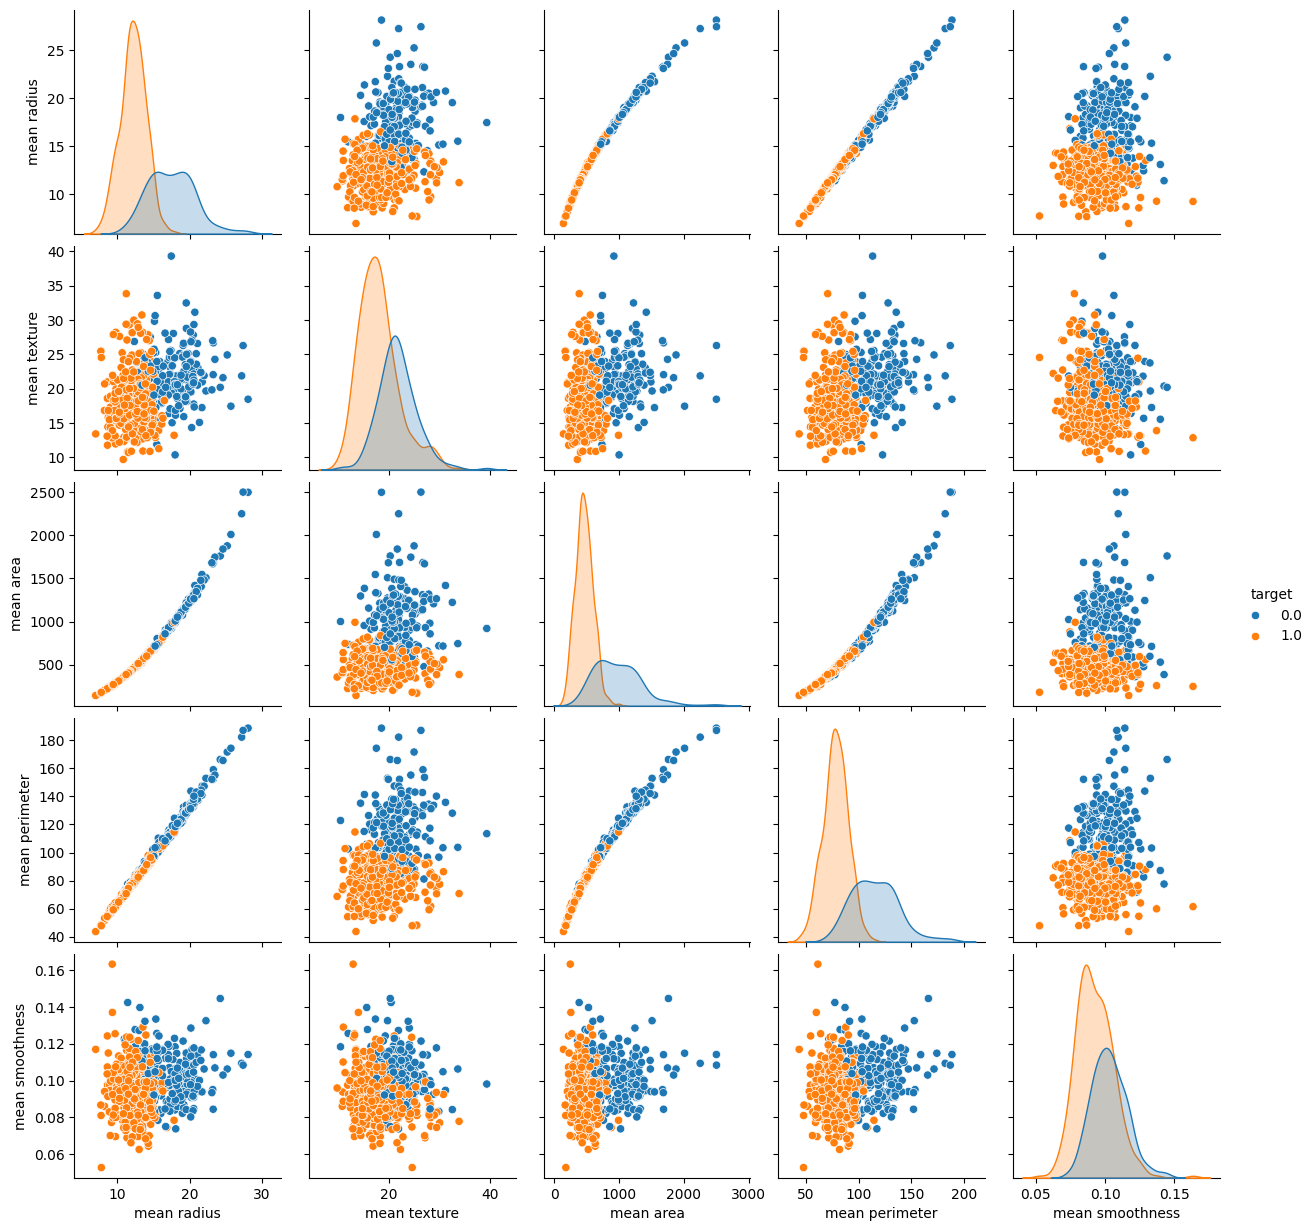

In [32]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
df_cancer = pd.DataFrame(np.c_[cancer['data'],cancer['target']], columns = np.append(cancer['feature_names'],['target']))
df_cancer.head()

df_cancer.replace([np.inf, -np.inf], np.nan, inplace=True)
sns.pairplot(df_cancer, hue = 'target', vars = ['mean radius', 'mean texture', 'mean area', 'mean perimeter', 'mean smoothness'])

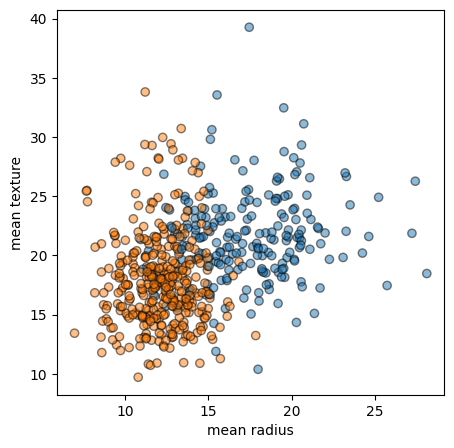

In [39]:
feature1 = 'mean radius'
feature2 = 'mean texture'

X = df_cancer[[feature1, feature2]].to_numpy()
y = df_cancer['target'].to_numpy()
y = np.array([-1.0 if x == 0 else x for x in y]).reshape(len(y), 1)

plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), alpha=0.5, cmap=matplotlib.colors.ListedColormap(colors), edgecolors="black")
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.show()

In [40]:
X = np.concatenate([X,X,X,X,X,X,X,X])
X.shape

(4552, 2)

In [41]:
y = np.concatenate([y,y,y,y,y,y,y,y])
y.shape

(4552, 1)

     pcost       dcost       gap    pres   dres  linear_solve_time  full_iter_time
 0: -1.0096e+04 -5.1900e+05  3e+05  1e+00  4e-10 1.4127e-01         1.0566e+01
 1: -8.5885e+03 -2.3861e+05  6e+04  2e-01  4e-10 1.4109e-01         9.0551e+00
 2: -7.7932e+03 -5.4181e+04  1e+04  2e-02  3e-10 1.4550e-01         1.0635e+01
 3: -8.6633e+03 -1.9869e+04  9e+03  4e-03  3e-10 1.3801e-01         1.0574e+01
 4: -9.4681e+03 -1.7918e+04  6e+03  3e-03  3e-10 1.4982e-01         1.0530e+01
 5: -1.0164e+04 -1.6038e+04  4e+03  2e-03  3e-10 1.3697e-01         9.0095e+00
 6: -1.0736e+04 -1.4671e+04  3e+03  9e-04  3e-10 1.3613e-01         9.9925e+00
 7: -1.1000e+04 -1.4027e+04  2e+03  6e-04  3e-10 1.4126e-01         1.0704e+01
 8: -1.1238e+04 -1.3509e+04  1e+03  4e-04  3e-10 1.3760e-01         1.1856e+01
 9: -1.1534e+04 -1.2910e+04  1e+03  2e-04  4e-10 1.3950e-01         8.9783e+00
10: -1.1664e+04 -1.2654e+04  5e+02  1e-04  4e-10 1.4301e-01         1.0046e+01
11: -1.1822e+04 -1.2368e+04  4e+02  5e-05  4e-10

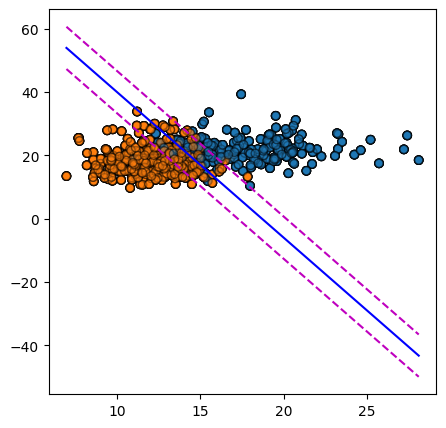

In [42]:
# Our simple implementation
model = SVM(kernel=linear_kernel, C=10.0)

# Train and time the model and time it
t0   = time.perf_counter()
model.fit(X,y)
t1   = time.perf_counter()

print('')
print('This implementation')
print("W:", model.w)
print("b:", model.b)
print(f"Trained in {t1 - t0:.3f} secs")

# Sklearn implementation (for comparison)
clf = svm.SVC(kernel="linear", C=10.0)

t0   = time.perf_counter()
clf.fit(X, y.ravel())
t1   = time.perf_counter()

w_sl = clf.coef_[0]
b_sl = clf.intercept_

print('')
print('Sklearn implementation')
print("W:", w_sl)
print("b:", b_sl)
print(f"Trained in {t1 - t0:.3f} secs")

# Plot the separating line with margins for our implementation
plot_margin(X, y, model)


In [28]:
start = time.time(); time.sleep(1); print(time.time() - start)

1.0042645931243896
